# Dvojke ali trojke

**Projektna naloga pri predmetu Programiranje 1**

Analiziral bom vse tekme lige NBA iz sezone 2020/2021. Vsa statistika je bila pridobljena s spletne strani [ESPN](https://www.espn.com/nba/scoreboard).

Začetne hipoteze:
1. Katere ekipe so imele uspešnejšo sezono - tiste, ki so pretežno metale za dve točki ali za tri točke?
2. Ali so bile v medsebojnih tekmah uspešnejše ekipe, ki so več metale za dve točki ali za tri točke?
3. Ali obstaja povezava med dominantnim načinom igre (igra pod košem ali igra z meti za tri točke) in ostalimi pomembnimi statističnimi podatki?

# 0. Priprava podatkov

Preden začnemo z analizo podatkov, jih moramo naprej uvesti, nato pa jih še dodatno obdelati. Potrebovali bomo, namreč, še nekaj podatkov, ki jih ne moremo direktno uvesti, ampak jih moramo izračunati iz uvezenih podatkov. 

In [295]:
import pandas as pd
tekme_redne = pd.read_csv('statistika-v-csv/tekme_redne.csv', index_col='Tekma',encoding = "utf-8")
ekipe = pd.read_csv('statistika-v-csv/ekipe.csv', index_col='Team',encoding = "utf-8")
pd.options.display.max_rows = 10
%matplotlib inline

Zdaj si lahko ogledamo podatke, ki smo jih uvezli. Prva tabela vsebuje podatke o vseh tekmah NBA lige v rednem delu sezone 2020/21. Okrajšave v tabeli imajo naslednje pomene:
* FG - število uspešnih in vseh metov iz igre (za dve in za tri točke skupaj, brez prostih metov)
* 3PT - število uspešnih in vseh metov za tri točke
* FT - število uspešnih in vseh prostih metov
* OREB - skoki v napadu
* DREB - skoki v obrambi
* REB - vsi skoki (v napadu in obrambi skupaj)
* AST - asistence
* STL - ukradene žoge
* BLK - blokirani meti na koš
* TO - izgubljene žoge
* PF - osebne napake
* PTS - končno število točk

In [296]:
tekme_redne

,Team,FG,3PT,FT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS
Tekma,,,,,,,,,,,,,
0,1,37-99,10-33,15-23,13,34,47,26,6,6,18,24,99
0,2,42-92,15-35,26-32,13,44,57,24,11,7,20,22,125
1,3,44-93,14-40,14-19,11,29,40,22,10,3,16,29,116
1,4,38-81,9-29,24-31,8,37,45,22,4,2,19,20,109
2,5,45-90,16-44,8-15,8,24,32,29,10,4,15,17,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,12,46-94,19-40,17-23,9,32,41,35,8,5,11,27,128
1100,22,44-98,14-37,14-15,10,26,36,20,8,2,6,20,116
1100,24,46-87,18-43,22-26,11,40,51,24,3,6,13,16,132


Druga tabela vsebuje identifikacijske številke NBA ekip s standardnimi okrajšavami njihovih imen:

In [297]:
ekipe

,Name
Team,
1,GS
2,BKN
3,LAC
4,LAL
5,CHA
...,...
28,DAL
29,MIL
30,BOS


Podatki o vseh treh tipih meta (iz igre, za tri točke, prosti met) so v obliki, v kateri bomo težko z njimi delali, zato jih spremenimo v bolj obvladljivo obliko. Ob tem še izbrišemo podatke o All-Star tekmi, ki nas ne bo zanimala, saj zelo odstopa od ostalih tekem.

In [298]:
tekme_redne = tekme_redne[tekme_redne.Team != 31] #izbrišemo All-Star tekmo
tekme_redne = tekme_redne[tekme_redne.Team != 32]
ekipe = ekipe.drop([31,32]) #izbrišemo All-Star ekipi
tekme_redne[["FGM", "FGA"]] = tekme_redne["FG"].str.split("-", expand = True)
tekme_redne[["3PM", "3PA"]] = tekme_redne["3PT"].str.split("-", expand = True)
tekme_redne[["FTM", "FTA"]] = tekme_redne["FT"].str.split("-", expand = True)
tekme_redne = tekme_redne.drop(columns=['FG','3PT','FT'])


Zaradi lažjega dela, spremenimo še tip podatkov v tabeli s tekmami.

In [299]:
tekme_redne = tekme_redne.astype(float)
tekme_redne["Team"] = tekme_redne["Team"].astype(int)

Zdaj pa se lotimo računanja podatkov, ki nas bodo zanimali za vsako posamezno tekmo. To so: uspešnost meta iz igre, meta za tri ter prostih metov in 3NG faktor, ki ga bomo kasneje opisali.

In [300]:
expected_value = 1.06
tekme_redne["FG%"] = 100 * tekme_redne["FGM"]/tekme_redne["FGA"]
tekme_redne["3P%"] = 100 * tekme_redne["3PM"]/tekme_redne["3PA"]
tekme_redne["FT%"] = 100 * tekme_redne["FTM"]/tekme_redne["FTA"]
tekme_redne["3NG"] = 3 * ((3 - expected_value) * tekme_redne["3PM"] - expected_value * (tekme_redne["3PA"] - tekme_redne["3PM"]))
tekme_redne["FG%"] = tekme_redne["FG%"].round(decimals=2)
tekme_redne["3P%"] = tekme_redne["3P%"].round(decimals=2)
tekme_redne["FT%"] = tekme_redne["FT%"].round(decimals=2)

Izačunamo še na kateri tekmi je kdo zmagal, da lahko dobimo lestvico na koncu sezone. 

In [301]:
zmaga_poraz_redne = []

for i in range(tekme_redne["PTS"].size):
    if i % 2 == 0:
        if tekme_redne["PTS"].iloc[i] > tekme_redne["PTS"].iloc[i + 1]:
            zmaga_poraz_redne.append(1)
        else:
            zmaga_poraz_redne.append(0)
    else:
        if tekme_redne["PTS"].iloc[i] > tekme_redne["PTS"].iloc[i - 1]:
            zmaga_poraz_redne.append(1)
        else:
            zmaga_poraz_redne.append(0)

tekme_redne["W/L"] = zmaga_poraz_redne

Ugotavljali bomo, ali obstaja kakšna zveza med metom za tri točke in številom točk, ki jih je ekipa prejela od nasprotnika, zato priskrbimo še slednji podatek za vsako tekmo posebej.

In [302]:
pts_against = []

for i in range(tekme_redne["PTS"].size//2):
    pts_against.append(tekme_redne["PTS"].iloc[2 * i + 1])
    pts_against.append(tekme_redne["PTS"].iloc[2 * i])

tekme_redne["PTSA"] = pts_against

Izračunamo vse statistične podatke vseh ekip skozi celotno sezono.

In [303]:
ekipe_redno_2 = tekme_redne.groupby("Team")
ekipe_redno = ekipe_redno_2.sum()
ekipe_redno["FG%"] = ekipe_redno["FG%"]/ekipe_redno_2.count()["FG%"]
ekipe_redno["3P%"] = ekipe_redno["3P%"]/ekipe_redno_2.count()["3P%"]
ekipe_redno["FT%"] = ekipe_redno["FT%"]/ekipe_redno_2.count()["FT%"]
ekipe_redno["3NG"] = 3 * ((3 - expected_value) * ekipe_redno["3PM"] - expected_value * (ekipe_redno["3PA"] - ekipe_redno["3PM"]))
ekipe_redno = ekipe_redno.rename(columns={"W/L" : "WINS"})
ekipe_redno["WIN%"] = 100 * ekipe_redno["WINS"]/ekipe_redno_2.count()["W/L"]

Na koncu le še uredimo izračunane podatke tako, da dobimo lestvice ekip na koncu sezone, in sicer glede na delež zmag, uspešnost meta za tri in 3NG faktor. S temi lestvicami dobimo vpogled v okvirne vrednosti podatkov, ki jih bomo obravnavali. Nove okrajšave v lestvicah imajo naslednje pomene:

* FGM - število uspešnih metov iz igre
* FGA - število vseh metov iz igre
* 3PM - število uspešnih metov za tri točke
* 3PA - število vseh metov za tri točke
* FTM - število uspešnih prostih metov
* FTA - število vseh prostih metov
* FG% - delež uspešnih metov iz igre glede na vse mete iz igre, izražen v procentih
* 3P% - delež uspešnih metov za tri točke glede na vse mete za tri točke, izražen v procentih
* FT% - delež uspešnih prostih metov glede na vse proste mete, izražen v procentih
* 3NG - 3NG koeficient
* WINS - število vseh zmag v sezoni
* PTSA - število točk, ki jih je ekipa prejela od vseh nasprotnikov skupaj
* WIN% - delež vseh zmag v sezoni glede na število vseh tekem v sezoni, izražen v procentih

In [304]:
lestvica_redno = pd.merge(ekipe, ekipe_redno, left_index=True, right_index=True)
lestvica_redno = lestvica_redno.sort_values(by='WIN%',ascending=False)
najuspesneje_za_tri = pd.merge(ekipe, ekipe_redno, left_index=True, right_index=True)
najuspesneje_za_tri = najuspesneje_za_tri.sort_values(by='3P%',ascending=False)
najboljsi_3NG = pd.merge(ekipe, ekipe_redno, left_index=True, right_index=True)
najboljsi_3NG = najboljsi_3NG.sort_values(by='3NG',ascending=False)

Lestvica glede na delež zmag

In [305]:
lestvica_redno

,Name,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,...,3PA,FTM,FTA,FG%,3P%,FT%,3NG,WINS,PTSA,WIN%
Team,,,,,,,,,,,,,,,,,,,,,
23,UTAH,765.0,2708.0,3473.0,1703.0,475.0,370.0,973.0,1335.0,8382.0,...,3098.0,1235.0,1546.0,46.914167,38.772917,79.325139,993.36,52,7716.0,72.222222
27,PHX,613.0,2380.0,2993.0,1882.0,505.0,298.0,838.0,1335.0,8071.0,...,2425.0,1101.0,1316.0,49.142429,37.759000,83.673714,532.50,49,7658.0,70.000000
12,PHI,722.0,2521.0,3243.0,1706.0,655.0,447.0,988.0,1456.0,8182.0,...,2169.0,1409.0,1836.0,47.688611,37.599444,76.752778,401.58,49,7780.0,68.055556
22,DEN,749.0,2419.0,3168.0,1908.0,575.0,322.0,910.0,1354.0,8176.0,...,2426.0,1106.0,1375.0,48.666197,37.876901,80.862958,529.32,47,7808.0,66.197183
2,BKN,620.0,2479.0,3099.0,1877.0,471.0,365.0,910.0,1327.0,8287.0,...,2535.0,1259.0,1568.0,49.445143,38.684429,80.265143,848.70,46,8021.0,65.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,CLE,751.0,2328.0,3079.0,1716.0,559.0,325.0,1039.0,1308.0,7476.0,...,2142.0,1200.0,1614.0,45.044028,33.663194,74.271250,-331.56,22,8084.0,30.555556
25,OKC,705.0,2531.0,3236.0,1556.0,496.0,316.0,1095.0,1291.0,7446.0,...,2493.0,1104.0,1520.0,44.150423,33.838732,72.642113,-349.74,21,8217.0,29.577465
10,ORL,746.0,2527.0,3273.0,1572.0,495.0,320.0,882.0,1235.0,7488.0,...,2287.0,1196.0,1543.0,42.935556,33.912361,77.584444,-216.66,21,8158.0,29.166667


Lestvica glede na uspešnost meta za tri

In [306]:
najuspesneje_za_tri

,Name,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,...,3PA,FTM,FTA,FG%,3P%,FT%,3NG,WINS,PTSA,WIN%
Team,,,,,,,,,,,,,,,,,,,,,
3,LAC,669.0,2473.0,3142.0,1724.0,500.0,291.0,877.0,1351.0,8088.0,...,2459.0,1144.0,1363.0,48.213944,41.164085,83.892254,1252.38,46,7656.0,64.788732
7,NY,697.0,2554.0,3251.0,1541.0,507.0,365.0,875.0,1473.0,7706.0,...,2163.0,1181.0,1506.0,45.657222,39.133611,78.591528,744.66,41,7540.0,56.944444
23,UTAH,765.0,2708.0,3473.0,1703.0,475.0,370.0,973.0,1335.0,8382.0,...,3098.0,1235.0,1546.0,46.914167,38.772917,79.325139,993.36,52,7716.0,72.222222
2,BKN,620.0,2479.0,3099.0,1877.0,471.0,365.0,910.0,1327.0,8287.0,...,2535.0,1259.0,1568.0,49.445143,38.684429,80.265143,848.70,46,8021.0,65.714286
24,POR,766.0,2441.0,3207.0,1531.0,496.0,364.0,775.0,1363.0,8360.0,...,2939.0,1282.0,1558.0,45.453611,38.602917,82.074583,841.98,42,8231.0,58.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,SA,659.0,2454.0,3113.0,1729.0,500.0,361.0,781.0,1285.0,7877.0,...,2023.0,1240.0,1565.0,46.191408,34.735634,79.381972,-52.14,33,8000.0,46.478873
10,ORL,746.0,2527.0,3273.0,1572.0,495.0,320.0,882.0,1235.0,7488.0,...,2287.0,1196.0,1543.0,42.935556,33.912361,77.584444,-216.66,21,8158.0,29.166667
26,HOU,671.0,2396.0,3067.0,1699.0,546.0,362.0,1026.0,1407.0,7833.0,...,2923.0,1189.0,1606.0,44.414583,33.865972,74.110694,-367.14,17,8402.0,23.611111


Lestvica glede na 3NG faktor

In [373]:
najboljsi_3NG

,Name,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,...,3PA,FTM,FTA,FG%,3P%,FT%,3NG,WINS,PTSA,WIN%
Team,,,,,,,,,,,,,,,,,,,,,
3,LAC,669.0,2473.0,3142.0,1724.0,500.0,291.0,877.0,1351.0,8088.0,...,2459.0,1144.0,1363.0,48.213944,41.164085,83.892254,1252.38,46,7656.0,64.788732
23,UTAH,765.0,2708.0,3473.0,1703.0,475.0,370.0,973.0,1335.0,8382.0,...,3098.0,1235.0,1546.0,46.914167,38.772917,79.325139,993.36,52,7716.0,72.222222
2,BKN,620.0,2479.0,3099.0,1877.0,471.0,365.0,910.0,1327.0,8287.0,...,2535.0,1259.0,1568.0,49.445143,38.684429,80.265143,848.70,46,8021.0,65.714286
24,POR,766.0,2441.0,3207.0,1531.0,496.0,364.0,775.0,1363.0,8360.0,...,2939.0,1282.0,1558.0,45.453611,38.602917,82.074583,841.98,42,8231.0,58.333333
29,MIL,707.0,2601.0,3308.0,1766.0,564.0,321.0,917.0,1192.0,8281.0,...,2560.0,1130.0,1486.0,48.700145,38.381884,76.200000,778.20,45,7890.0,65.217391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,DET,681.0,2345.0,3026.0,1704.0,519.0,367.0,1009.0,1449.0,7547.0,...,2329.0,1265.0,1662.0,45.142113,34.958310,75.956761,-98.22,19,7893.0,26.760563
10,ORL,746.0,2527.0,3273.0,1572.0,495.0,320.0,882.0,1235.0,7488.0,...,2287.0,1196.0,1543.0,42.935556,33.912361,77.584444,-216.66,21,8158.0,29.166667
6,CLE,751.0,2328.0,3079.0,1716.0,559.0,325.0,1039.0,1308.0,7476.0,...,2142.0,1200.0,1614.0,45.044028,33.663194,74.271250,-331.56,22,8084.0,30.555556


V nadaljevanju bomo obravnavali vpliv meta za tri točke na dva načina. Najprej bomo pogledali, kako met za tri točke vpliva na rezultate ekip v celotni sezoni, nato pa še vpliv meta za tri točke na posameznih tekmah. Izkazalo se bo, da je vpliv na uspešnost ekip dejansko različen v teh dveh primerih.

# 1. Vpliv metov za tri točke na uspešnost ekip na koncu sezone

Pogledali bomo, kako trije ključni faktorji, povezani z metom za tri točke, vplivajo na uspešnost ekip na koncu sezone. Ti faktorji so: število metov za tri točke (3PA), uspešnost meta za tri točke (3P%) in 3NG koeficient, ki je definiran na naslednji način: 
$$ \mathit{3NG = 3 * (3PM * (3 - EV) - (3PA - 3PM) * EV) = (3 * 3P\% - EV) * 3PA}, $$
kjer je $EV$ število točk, ki ga bo neka ekipa dosegla v povprečju v enem napadu, če vso tekmo meče le za dve točki. V tej analizi smo privzeli, da je $EV = 1,06$. Za zdaj opazimo le, da je 3NG odvisen tako od števila metov za tri točke, kot tudi od uspešnosti meta za tri točke, kasneje pa se bomo temu koeficientu posvetili še podrobneje.

<AxesSubplot:xlabel='Število vseh metov za tri', ylabel='Delež zmag izmed vseh tekem [%]'>

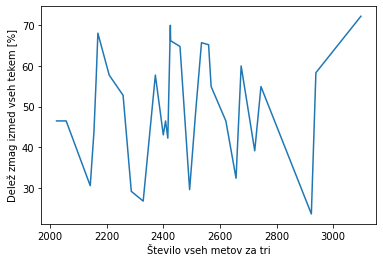

In [308]:
lestvica_redno.groupby("3PA")["WIN%"].mean().plot(xlabel="Število vseh metov za tri", ylabel="Delež zmag izmed vseh tekem [%]")

Prvi graf jasno kaže, da število vseh metov za tri ne vpliva na uspeh ekipe v celotni sezoni.

<AxesSubplot:xlabel='Uspešnost meta za tri [%]', ylabel='Delež zmag izmed vseh tekem [%]'>

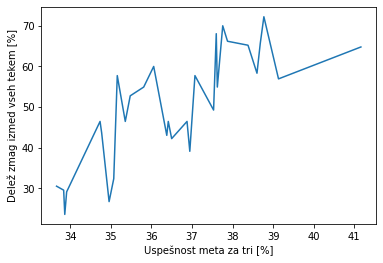

In [309]:
lestvica_redno.groupby("3P%")["WIN%"].mean().plot(xlabel="Uspešnost meta za tri [%]", ylabel="Delež zmag izmed vseh tekem [%]")

Iz drugega grafa je razvidno, da je delež zmag v celotni sezoni močno povezan s tem, kako uspešno je neka ekipa metala za tri točke.

<AxesSubplot:xlabel='3NG koeficient', ylabel='Delež zmag izmed vseh tekem [%]'>

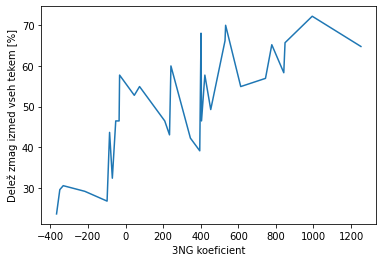

In [310]:
ekipe_redno.groupby("3NG")["WIN%"].mean().plot(xlabel="3NG koeficient", ylabel="Delež zmag izmed vseh tekem [%]")

Tretji graf nam pokaže, da je delež zmag v sezoni odvisen tudi od 3NG koeficienta, kar je bilo tudi pričakovano, saj je slednji odvisen od uspešnosti meta za tri, ki vpliva na uspešnost ekipe (drugi graf), in števila metov za tri, ki pa ne vpliva na delež zmag (prvi graf). Torej je bil pričakovani vpliv koeficienta 3NG enak vplivu uspešnosti meta za tri.

Torej, ko pogledamo celotno sezono, je število metov za tri nepomembno, uspešnost meta za tri pa je zelo pomembna. S tem smo odgovorili na vprašanje iz naše prve hipoteze. Vendar se slika spremeni, ko ne opazujemo sezone v celoti, temveč posamezne tekme.

# 2. Vpliv metov za tri točke na uspešnost ekip na posamezni tekmi

Da bi lahko primerjali uspešnost ekip na posameznih tekmah glede na to, kako uspešno in koliko so metale za tri točke, izračunamo nekaj dodatnih statističnih podatkov.

In [382]:
razlika_v_tockah = []
razlika_v_delezu_meta_za_tri = []
povprecje_meta_za_tri = []
razlika_v_metu_za_tri = []
razlika_v_metu_za_tri_sezona = []
razlika_3NG = []

for i in range(tekme_redne["3P%"].size//2):
    razlika_v_delezu_meta_za_tri.append(tekme_redne["3P%"].iloc[2 * i] - tekme_redne["3P%"].iloc[2 * i + 1])
    razlika_v_metu_za_tri.append(tekme_redne["3PA"].iloc[2 * i] - tekme_redne["3PA"].iloc[2 * i + 1])
    razlika_v_tockah.append(tekme_redne["PTS"].iloc[2 * i] - tekme_redne["PTS"].iloc[2 * i + 1])
    razlika_v_delezu_meta_za_tri.append(tekme_redne["3P%"].iloc[2 * i + 1] - tekme_redne["3P%"].iloc[2 * i])
    razlika_v_metu_za_tri.append(tekme_redne["3PA"].iloc[2 * i + 1] - tekme_redne["3PA"].iloc[2 * i])
    razlika_v_tockah.append(tekme_redne["PTS"].iloc[2 * i + 1] - tekme_redne["PTS"].iloc[2 * i])
    prva_ekipa = tekme_redne["Team"].iloc[2 * i]
    druga_ekipa = tekme_redne["Team"].iloc[2 * i + 1]
    razlika_v_metu_za_tri_sezona.append(ekipe_redno["3P%"].loc[prva_ekipa] - ekipe_redno["3P%"].loc[druga_ekipa])
    razlika_v_metu_za_tri_sezona.append(ekipe_redno["3P%"].loc[druga_ekipa] - ekipe_redno["3P%"].loc[prva_ekipa])
    razlika_3NG.append(tekme_redne["3NG"].iloc[2 * i] - tekme_redne["3NG"].iloc[2 * i + 1])
    razlika_3NG.append(tekme_redne["3NG"].iloc[2 * i + 1] - tekme_redne["3NG"].iloc[2 * i])
    povprecje_meta_za_tri.extend(2 * [(tekme_redne["3P%"].iloc[2 * i + 1] + tekme_redne["3P%"].iloc[2 * i])/2])

data = {"PTS DIFF" : razlika_v_tockah, "3P% DIFF": razlika_v_delezu_meta_za_tri, "3P% DIFF SEASON" : razlika_v_metu_za_tri_sezona, "3PA DIFF" : razlika_v_metu_za_tri,
        "3NG DIFF" : razlika_3NG, "3P% AVG" : povprecje_meta_za_tri, "3NG" : tekme_redne["3NG"], "3P%" : tekme_redne["3P%"]}
tekme_redne2 = pd.DataFrame(data)
tekme_redne2 = tekme_redne2.rename_axis(index="Tekma")

Tako kot v prvem delu te analize bomo pogledali, kako uspešnost meta za tri točke, število metov za tri točke in koeficient 3NG vplivajo na uspešnost ekip, vendar bomo tokrat opazovali uspešnost ekip na posameznih tekmah.

<AxesSubplot:xlabel='Razlika v uspešnosti meta za tri glede na nasprotno ekipo [%]', ylabel='Povprečna razlika v doseženih točkah glede na nasprotno ekipo'>

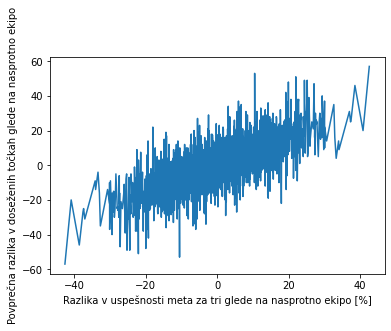

In [312]:
tekme_redne2.groupby("3P% DIFF")["PTS DIFF"].mean().plot(xlabel="Razlika v uspešnosti meta za tri glede na nasprotno ekipo [%]", ylabel="Povprečna razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:xlabel='Razlika v uspešnosti meta za tri glede na nasprotno ekipo [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

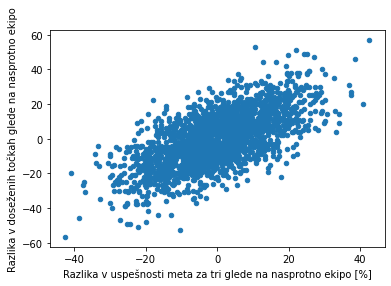

In [313]:
tekme_redne2.plot.scatter("3P% DIFF","PTS DIFF",xlabel="Razlika v uspešnosti meta za tri glede na nasprotno ekipo [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

Kot pričakovano, na prejšnjih dveh grafih vidimo, da uspešneje kot so ekipe metale za tri točke od svojih nasprotnikov, več točk so od njih dosegale v povprečju.

<AxesSubplot:xlabel='Razlika v številu metov za tri glede na nasprotno ekipo', ylabel='Povprečna razlika v doseženih točkah glede na nasprotno ekipo'>

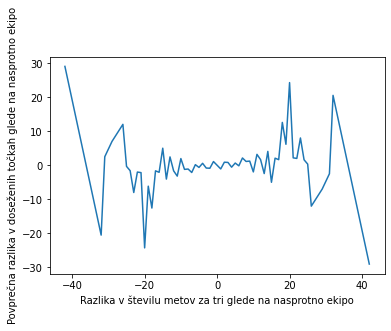

In [314]:
tekme_redne2.groupby("3PA DIFF")["PTS DIFF"].mean().plot(xlabel="Razlika v številu metov za tri glede na nasprotno ekipo", ylabel="Povprečna razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:xlabel='Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

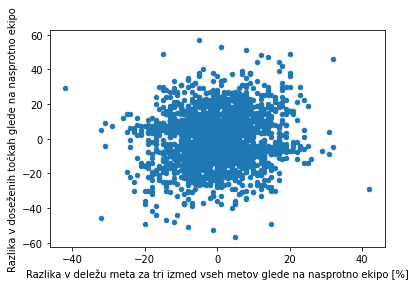

In [315]:
tekme_redne2.plot.scatter("3PA DIFF", "PTS DIFF", xlabel="Razlika v deležu meta za tri izmed vseh metov glede na nasprotno ekipo [%]", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

Glede na ugotovitve iz prvega dela te analize bi pričakovali, da bo tudi na posameznih tekmah vseeno, kako pogosto je neka ekipa metala za tri točke. Vendar predhodna grafa jasno kažeta, da je to le do neke mere res. Opazimo, da je na tekmah, na katerih se je število metov za tri točke med ekipama razlikovalo za največ 15 metov, bilo vseeno, katera ekipa je metala za tri točke pogosteje, katera pa redkeje. Vendar pa lahko prav tako opazimo, da je na tekmah, na katerih se je število metov za tri točke med ekipama razlikovalo za več kot 15 metov, bilo število metov za tri točke precej pomembno. V kratkem bomo natančneje raziskali, kdaj je bilo pomembno in kakšen vpliv je imelo v teh primerih.

<AxesSubplot:xlabel='Razlika v 3NG koeficientu glede na nasprotno ekipo', ylabel='Povprečna razlika v doseženih točkah glede na nasprotno ekipo'>

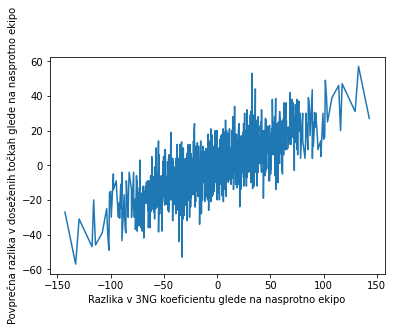

In [316]:
tekme_redne2.groupby("3NG DIFF")["PTS DIFF"].mean().plot(xlabel="Razlika v 3NG koeficientu glede na nasprotno ekipo", ylabel="Povprečna razlika v doseženih točkah glede na nasprotno ekipo")

<AxesSubplot:xlabel='Razlika v 3NG koeficientu glede na nasprotno ekipo', ylabel='Razlika v doseženih točkah glede na nasprotno ekipo'>

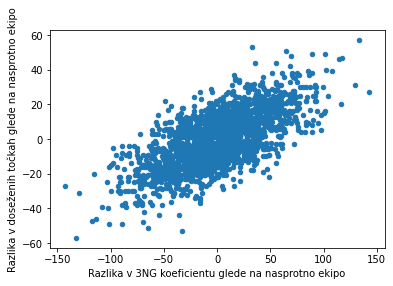

In [317]:
tekme_redne2.plot.scatter("3NG DIFF","PTS DIFF", xlabel="Razlika v 3NG koeficientu glede na nasprotno ekipo", ylabel="Razlika v doseženih točkah glede na nasprotno ekipo")

Zgornja dva grafa potrdita pričakovan rezultat, da je 3NG koeficient pomemben tudi za izid posameznih tekem. Pokažeta nam, da večji kot bo imela ekipa 3NG, več točk bo dosegla v primerjavi z nasprotno ekipo.

Ugotovili smo, da je uspešnost meta za tri točke precej pomembnejša kot število metov za tri točke. Vendar smo pa prav tako opazili, da število metov za tri točke ni vedno nepomembno. Poskusimo ugotoviti, v kakšni meri je slednji statistični podatek pomemben.

# 3. Pomembnost števila metov za tri točke v posebnih primerih

Tudi v tem poglavju še vedno opazujemo vpliv meta za tri točke na posamezni tekmi. Obravnali bomo dva posebna primera, v katerih je število metov za tri točke pomembno. Najprej bomo pogledali teoretično razlago, zakaj naj bi sploh bilo pomembno število metov za tri točke. Preko te razlage bomo prišli do ideje za prvi posebni primer in ga bomo raziskali. Nato pa bomo obravnavali še drugi posebni primer, ki smo ga že omenili v prejšnjem poglavju, in sicer tekme, na katerih ekipi mečeta za tri točke zelo različno veliko.

## 3.1. 3NG koeficient - teoretičen pomen števila metov za tri točke

3NG koeficient je statistični podatek, ki natančneje kot navadna uspešnost meta za tri točke pove, koliko je ekipa pridobila z metanjem za tri točke v neki tekmi. Zapišimo še enkrat definicijo koeficienta:
$$ \mathit{3NG = 3 * (3PM * (3 - EV) - (3PA - 3PM) * EV) = (3 * 3P\% - EV) * 3PA}, $$
kjer je $EV$ število točk, ki ga bo neka ekipa dosegla v povprečju v enem napadu, če vso tekmo meče le za dve točki. V tej analizi smo privzeli, da je $EV = 1,06$. 3NG je zasnovan na poenostavitvi, da lahko v vsakem napadu ekipa dejansko doseže $EV$ točk, kar je nemogoče, saj lahko dosežemo le eno, dve, tri ali štiri. Vendar se vseeno omejimo na ta približek in denimo, da je mogoče doseči $1,06$ točk v enem napadu. Ideja koeficienta 3NG je, da lahko ekipa v vsakem napadu meče le za dve ali za tri točke. Če vrže za dve bo zagotovo zadela in dobila $EV$ točk, če vrže za tri točke pa bo ali dobila $0$, če zgreši, ali $3$ točke, če zadane. Torej bo za vsak zadeti met za tri točke pridobila $3 - EV$ točk, za vsak zgrešeni met za tri točke pa bo izgubila $EV$ točk. 3NG pa je vsota vseh pridobljenih in izgubljenih točk (ki je lahko tako pozitivna kot tudi negativna). Opisano idejo povzame zgornja formula.

Če privzamemo, da je 3NG koeficient smiselno merilo uspešnosti ekipe, bi v teoriji morala uspešnost ekipe biti odvisna tudi od števila metov za tri točke, saj je od tega odvisen 3NG koeficient. Ob tem smo že ugotovili, da je v praksi uspešnost meta za tri točke veliko pomembnejša od števila metov za tri točke. Če se želimo pri opazovanju pomembnosti števila metov za tri točke izogniti vplivu uspešnosti meta za tri točke, moramo opazovati ekipe, ki so približno enako uspešno metale za tri točke. Pri konstantni uspešnosti meta koeficient 3NG ne bo konstanten, temveč se bo spreminjal glede na število metov za tri točke. Iz tega izhaja, da bi, po (poenostavljeni) teoriji, na tekmah, na katerih so igrale ekipe, ki so približno enako uspešno metale za tri točke, moralo biti pomembno število metov za tri točke.

Odvisnost 3NG od uspešnih in vseh metov za tri točke je prikazana na spodnjem grafu, na katerem je tudi jasno razvidno, da bo pri npr. 100% metu za tri točke 3NG naraščal s številom metov. Podobno lahko za vsako drugo konstantno uspešnost meta za tri točke razberemo, da 3NG ni konstanten.

In [318]:
vrednosti_3NG = [[],[],[]]

for i in range(100):
    for j in range(i,100):
        vrednosti_3NG[0].append(i)
        vrednosti_3NG[1].append(j)
        vrednosti_3NG[2].append(3 * ((3 - expected_value) * i - expected_value * (j - i)))

data = {"3PM" : vrednosti_3NG[0], "3PA" : vrednosti_3NG[1], "3NG" : vrednosti_3NG[2]}
graf_3NG = pd.DataFrame(data)

C:\Users\mkocb\AppData\Local\Temp/ipykernel_11352/2154685817.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure().gca(projection='3d')


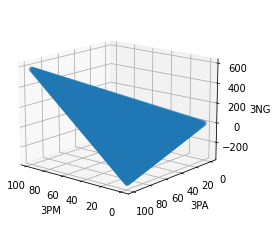

In [319]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure().gca(projection='3d')
threedee.scatter(graf_3NG["3PM"], graf_3NG["3PA"], graf_3NG['3NG'])
threedee.set_xlabel('3PM')
threedee.set_ylabel('3PA')
threedee.set_zlabel('3NG')
threedee.view_init(15,130)
plt.show()

## 3.2. Prvi posebni primer - primerjava ekip, ki so približno enako uspešno metale za tri točke

Naslednji graf prikazuje razlike v točkah na posameznih tekmah med ekipama, ki sta na tej tekmi približno enako uspešno metali za tri, v odvisnosti od tega, kakšna je razlika v številu metov za tri točke med ekipama in kakšna je bila povprečna uspešnost meta za tri točke obeh ekip.

C:\Users\mkocb\AppData\Local\Temp/ipykernel_11352/2932534255.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure().gca(projection='3d')


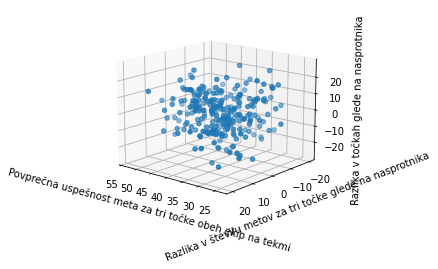

In [362]:
priblizno_enakovredne_tekme = tekme_redne2[abs(tekme_redne2["3P% DIFF"]) < 2]
threedee = plt.figure().gca(projection='3d')
threedee.scatter(priblizno_enakovredne_tekme["3P% AVG"], priblizno_enakovredne_tekme["3PA DIFF"], priblizno_enakovredne_tekme['PTS DIFF'])
threedee.set_xlabel('Povprečna uspešnost meta za tri točke obeh ekip na tekmi')
threedee.set_ylabel('Razlika v številu metov za tri točke glede na nasprotnika')
threedee.set_zlabel('Razlika v točkah glede na nasprotnika')
threedee.view_init(15,130)
plt.show()

Ta 3D graf je precej nepregleden, ker smo naenkrat obravnavali preveč ekip, ki so različno uspešno metale za tri točke. Zato poglejmo 2D grafe pri različnih povprečnih uspešnostih metov za tri točke obeh ekip.

<AxesSubplot:title={'center':'Povprečna uspešnost meta za tri točke obeh ekip med 25% in 30%'}, xlabel='Razlika v številu metov za tri točke glede na nasprotnika', ylabel='Razlika v doseženih točkah glede na nasprotnika'>

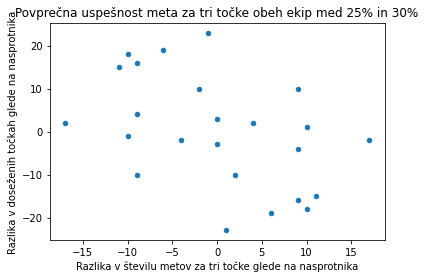

In [365]:
priblizno_enakovredne_tekme = tekme_redne2[(abs(tekme_redne2["3P% DIFF"]) < 2) & ((tekme_redne2["3P% AVG"] >= 25) & (tekme_redne2["3P% AVG"] <= 30))]
priblizno_enakovredne_tekme.plot.scatter("3PA DIFF","PTS DIFF", title="Povprečna uspešnost meta za tri točke obeh ekip med 25% in 30%",xlabel="Razlika v številu metov za tri točke glede na nasprotnika", ylabel="Razlika v doseženih točkah glede na nasprotnika")

<AxesSubplot:title={'center':'Povprečna uspešnost meta za tri točke obeh ekip med 25% in 30%'}, xlabel='Razlika v številu metov za tri točke glede na nasprotnika', ylabel='Razlika v doseženih točkah glede na nasprotnika'>

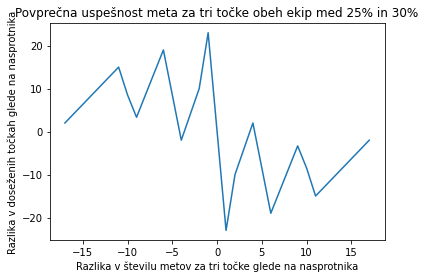

In [366]:
priblizno_enakovredne_tekme.groupby("3PA DIFF")["PTS DIFF"].mean().plot(title="Povprečna uspešnost meta za tri točke obeh ekip med 25% in 30%",xlabel="Razlika v številu metov za tri točke glede na nasprotnika", ylabel="Razlika v doseženih točkah glede na nasprotnika")

Opazimo, da graf pokaže, da so na tekmah, na katerih sta obe ekipi metali približno enako slabo za tri, praviloma izgubljale ekipe, ki so več metale za tri. Če pa pogledamo naslednje grafe, ki prikazujejo tekme, na katerih so ekipe za tri točke metale približno enako dobro in ne pretirano slabo, vidimo, da ne moremo zaslediti več nikakršnega pravila.

<AxesSubplot:title={'center':'Povprečna uspešnost meta za tri točke obeh ekip med 35% in 40%'}, xlabel='Razlika v številu metov za tri točke glede na nasprotnika', ylabel='Razlika v doseženih točkah glede na nasprotnika'>

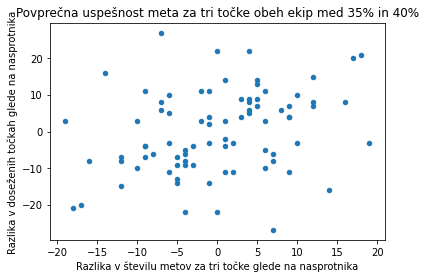

In [367]:
priblizno_enakovredne_tekme = tekme_redne2[(abs(tekme_redne2["3P% DIFF"]) < 2) & ((tekme_redne2["3P% AVG"] >= 35) & (tekme_redne2["3P% AVG"] <= 40))]
priblizno_enakovredne_tekme.plot.scatter("3PA DIFF","PTS DIFF",title="Povprečna uspešnost meta za tri točke obeh ekip med 35% in 40%",xlabel="Razlika v številu metov za tri točke glede na nasprotnika", ylabel="Razlika v doseženih točkah glede na nasprotnika")

<AxesSubplot:title={'center':'Povprečna uspešnost meta za tri točke obeh ekip med 35% in 40%'}, xlabel='Razlika v številu metov za tri točke glede na nasprotnika', ylabel='Razlika v doseženih točkah glede na nasprotnika'>

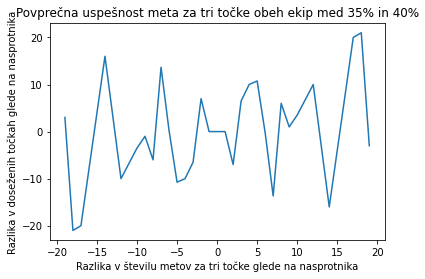

In [368]:
priblizno_enakovredne_tekme.groupby("3PA DIFF")["PTS DIFF"].mean().plot(title="Povprečna uspešnost meta za tri točke obeh ekip med 35% in 40%",xlabel="Razlika v številu metov za tri točke glede na nasprotnika", ylabel="Razlika v doseženih točkah glede na nasprotnika")

<AxesSubplot:title={'center':'Povprečna uspešnost meta za tri točke obeh ekip med 45% in 50%'}, xlabel='Razlika v številu metov za tri točke glede na nasprotnika', ylabel='Razlika v doseženih točkah glede na nasprotnika'>

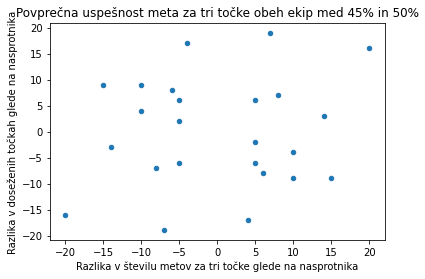

In [369]:
priblizno_enakovredne_tekme = tekme_redne2[(abs(tekme_redne2["3P% DIFF"]) < 2) & ((tekme_redne2["3P% AVG"] >= 45) & (tekme_redne2["3P% AVG"] <= 50))]
priblizno_enakovredne_tekme.plot.scatter("3PA DIFF","PTS DIFF",title="Povprečna uspešnost meta za tri točke obeh ekip med 45% in 50%",xlabel="Razlika v številu metov za tri točke glede na nasprotnika", ylabel="Razlika v doseženih točkah glede na nasprotnika")

<AxesSubplot:title={'center':'Povprečna uspešnost meta za tri točke obeh ekip med 45% in 50%'}, xlabel='Razlika v številu metov za tri točke glede na nasprotnika', ylabel='Razlika v doseženih točkah glede na nasprotnika'>

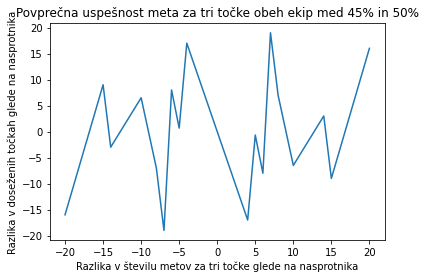

In [370]:
priblizno_enakovredne_tekme.groupby("3PA DIFF")["PTS DIFF"].mean().plot(title="Povprečna uspešnost meta za tri točke obeh ekip med 45% in 50%",xlabel="Razlika v številu metov za tri točke glede na nasprotnika", ylabel="Razlika v doseženih točkah glede na nasprotnika")

Torej je število metov za tri točke v posebnem primeru, ko ekipi enako uspešno mečeta, pomembno le, če ekipi slabo mečeta za tri točke. Tedaj je, logično, boljše za takšne ekipe, da čim manj mečejo za tri. Presenetljivo je, da v primeru, ko obe ekipi uspešno mečeta za tri točke, ne gre boljše ekipi, ki ima večje število metov za tri točke. Razlog je verjetno v tem, da te ekipe mečejo zelo dobro tudi za dve točki in zato manj metov za tri točke nadoknadijo z več uspešnimi meti za dve točki.

Vrnimo se sedaj na pojav, ki nas je sploh navedel na to, da pogledamo pomen števila metov za tri točke v posebnih primerih. Spomnimo se grafa, ki je prikazoval povprečno razliko v doseženih točkah glede na nasprotno ekipo v odvisnosti od razlike v številu metov za tri točke glede na nasprotno ekipo:

<AxesSubplot:xlabel='Razlika v številu metov za tri glede na nasprotno ekipo', ylabel='Povprečna razlika v doseženih točkah glede na nasprotno ekipo'>

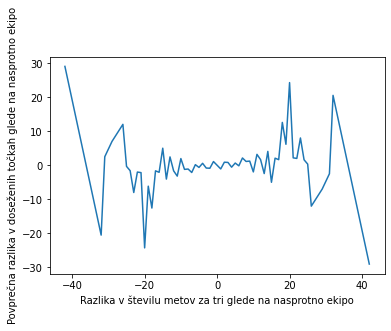

In [327]:
tekme_redne2.groupby("3PA DIFF")["PTS DIFF"].mean().plot(xlabel="Razlika v številu metov za tri glede na nasprotno ekipo", ylabel="Povprečna razlika v doseženih točkah glede na nasprotno ekipo")

Opazili smo, da je do neke razlike v številu metov za tri točke med nasprotnima ekipama ta razlika bila nepomembna za izid tekme, ko pa je prišla čez neko mejo, je postala precej pomembna. Primerjajmo torej zdaj ekipe, ki so metale zelo različno veliko za tri točke, neodvisno od tega, kako dobro so metale za tri.

# 3.3 Drugi posebni primer - primerjava ekip, ki so metale zelo različno veliko za tri točke

Poglejmo si na naslednjih grafih podrobneje, kako velika je morala biti med ekipama razlika v številu metov za tri točke, da je postala pomembna, in kako je v teh primerih vplivala na izid tekme:

In [328]:
def precej_razlicne(zacetek, konec):
    zelo_razlicne = tekme_redne2[(abs(tekme_redne2["3PA DIFF"]) >= zacetek) & (abs(tekme_redne2["3PA DIFF"]) <= konec)]
    x = zelo_razlicne[(zelo_razlicne["3PA DIFF"] > 0) & (zelo_razlicne["PTS DIFF"] > 0)].count()["PTS DIFF"]
    y = zelo_razlicne[(zelo_razlicne["3PA DIFF"] < 0) & (zelo_razlicne["PTS DIFF"] > 0)].count()["PTS DIFF"]
    histogram = pd.DataFrame({"Način metanja" : ["Za dva", "Za tri"], "Število medsebojnih zmag" : [y, x]})
    histogram.plot.bar(title =f'Tekme, na katerih se je število metov za tri med ekipama razlikovalo za najmanj {zacetek} in največ {konec}', x = "Način metanja", y = "Število medsebojnih zmag").legend(loc='lower left')

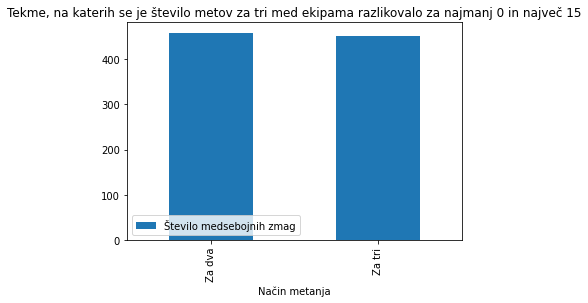

In [371]:
precej_razlicne(0,15)

S tem grafom smo še enkrat potrdili, da dokler je razlika v številu metov za tri točke manjša od 15 metov, le-ta ne vpliva ne izid tekme. Ločimo zdaj primera, ko je razlika v številu metov za tri točke med 16 in 20 metov ter ko je ta razlika večja od 20 metov:

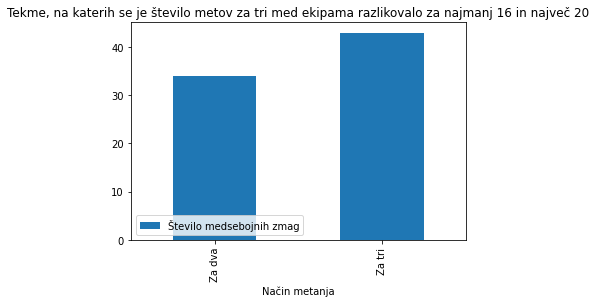

In [330]:
precej_razlicne(16,20)

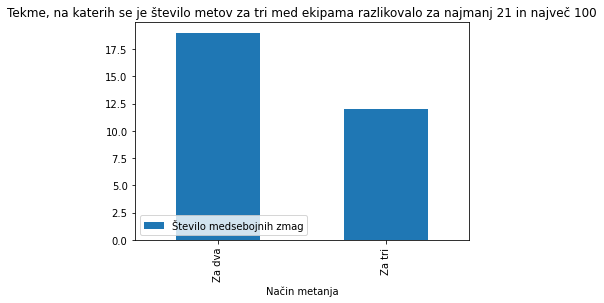

In [331]:
precej_razlicne(21,100)

Opazimo zanimiv pojav. Na tekmah, kjer je razlika v deležu meta za tri bila precejšnja, ne pa prevelika so bile dosti uspešnejše ekipe, ki so več metale za tri. Še zanimiveje pa je, da se pri zelo velikih razlikah v deležu meta za tri, to razmerje obrne, in so na teh tekmah bile veliko uspešnejše ekipe, ki so več metale za dve točki. Pri slednji ugotovitvi, je treba imeti v vidu, da je takšnih tekem bilo le 31, in zato nimamo dovolj velikega vzorca, da bi lahko karkoli z gotovostjo trdili, imamo pa vseeno nek kazatelj.

Te ugotovitve nam porodijo več vprašanj:

1. Če število metov za tri predstavlja na posameznih tekmah nezanemarljiv faktor, zakaj je potem nepomemben, ko gledamo rezultate na koncu celotne sezone (kot smo ugotovili na prvih grafih)?
2. Zakaj so bile na tekmah, kjer je razlika v številu metov za tri bila precejšnja, ne pa prevelika, bile uspešnejše ekipe, ki so več metale za tri?
3. Zakaj se je razmerje iz druge točke obrnilo v korist ekip, ki so metale več za dve točki, ko je razlika v številu metov za tri točke postala zelo velika?

Poskusimo odgovoriti oz. postaviti nove hipoteze:

1. Število tekem, na katerih je število metov za tri nezanemarljiv faktor, je devetkrat manjše od števila vseh tekem v sezoni, zato imajo te tekme precej majhen vpliv na statistiko cele sezone in zato postane število metov za tri zanemarljiv faktor, ko opazujemo celotno sezono.
2. Postavimo hipotezo, da so na takšnih tekmah več metale za tri točke ekipe, ki so se počutile samozavestno, ker so dejansko uspešno metale za tri točke. To bomo preverili s primerjavo povprečne uspešnosti meta za tri točke in povprečnega 3NG koeficienta ekip.
3. Postavimo hipotezo, da so na takšnih tekmah ekipe pretiravale z metanjem za tri točke, čeprav niso v tem bile uspešne. Tudi to bomo preverili s primerjavo povprečne uspešnosti meta za tri točke in povprečnega 3NG koeficienta.

Primerjajmo zdaj povprečne uspešnosti meta za tri točke in 3NG koeficiente ekip, ki so več metale za dve točki, in ekip, ki so več metale za tri točke, na tekmah, ki so opisane v drugem in tretjem vprašanju, ki smo ga postavili:

In [391]:
def primerjaj_3P(zacetek, konec):
    zelo_razlicne = tekme_redne2[(abs(tekme_redne2["3PA DIFF"]) >= zacetek) & (abs(tekme_redne2["3PA DIFF"]) <= konec)]
    x = zelo_razlicne[(zelo_razlicne["3PA DIFF"] > 0)].mean()["3P%"]
    y = zelo_razlicne[(zelo_razlicne["3PA DIFF"] < 0)].mean()["3P%"]
    histogram = pd.DataFrame({"Način metanja" : ["Za dva", "Za tri"], "Povprečen 3P%" : [y, x]})
    histogram.plot.bar(title =f'Tekme, na katerih se je število metov za tri med ekipama razlikovalo za najmanj {zacetek} in največ {konec}', x = "Način metanja", y = "Povprečen 3P%").legend(loc='lower left')

def primerjaj_3NG(zacetek, konec):
    zelo_razlicne = tekme_redne2[(abs(tekme_redne2["3PA DIFF"]) >= zacetek) & (abs(tekme_redne2["3PA DIFF"]) <= konec)]
    x = zelo_razlicne[(zelo_razlicne["3PA DIFF"] > 0)].mean()["3NG"]
    y = zelo_razlicne[(zelo_razlicne["3PA DIFF"] < 0)].mean()["3NG"]
    histogram = pd.DataFrame({"Način metanja" : ["Za dva", "Za tri"], "Povprečen 3NG" : [y, x]})
    histogram.plot.bar(title =f'Tekme, na katerih se je število metov za tri med ekipama razlikovalo za najmanj {zacetek} in največ {konec}', x = "Način metanja", y = "Povprečen 3NG").legend(loc='lower left')

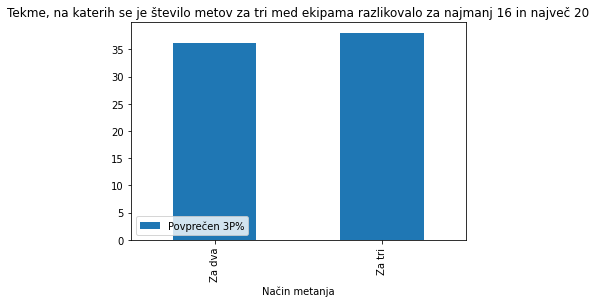

In [388]:
primerjaj_3P(16,20)

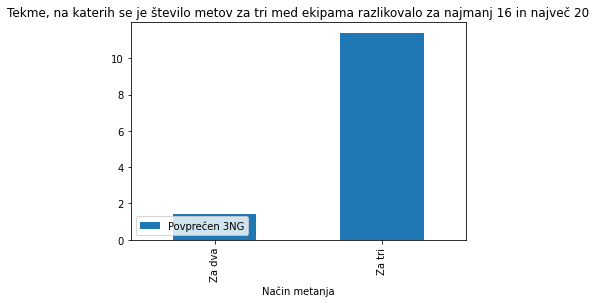

In [392]:
primerjaj_3NG(16,20)

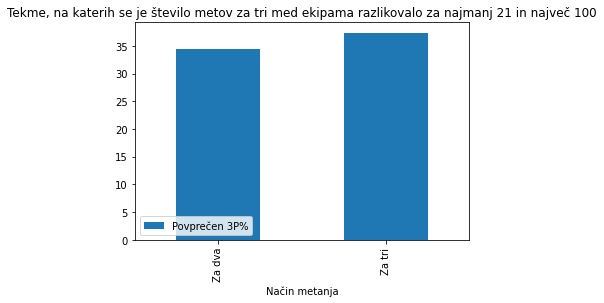

In [389]:
primerjaj_3P(21,100)

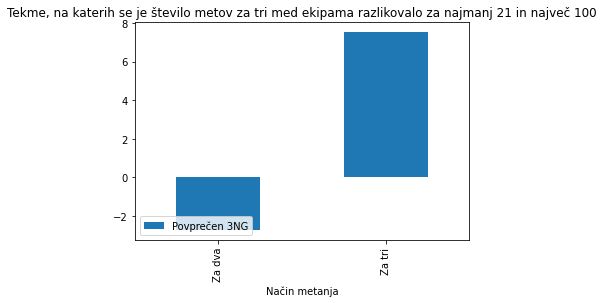

In [393]:
primerjaj_3NG(21,100)

S prvega grafa je razvidno, da je druga hipoteza napačna, saj je uspešnost meta za tri točke bila v povprečju enaka pri ekipah, ki so metale manj in več za tri točke. Z drugega grafa je razvidno, da je 3NG ekip, ki so več metale za tri točke, bil dosti večji od ostalih ekip. To je zelo zanimivo, saj to pomeni, da je dejansko ključni vpliv za visok 3NG in s tem dobre rezultate ekip, ki so veliko metale za tri točke, imelo število število metov za tri točke. Prav tako je tretja hipoteza napačna, saj so ekipe, ki so veliko metale za tri točke, imele nadpovprečen 3NG koeficient, torej ni bil vzrok za njihove poraze to, da so pretiravale z metom.

Žal, nismo uspeli najti odgovora, zakaj pride do opisane anomalije na tekmah, na katerih ima ena ekipa več kot dvajset metov za tri točke več od druge ekipe. Ker odgovora nismo našli in ker je takšnih tekem zelo malo, ne bomo o njih ničesar sklepali. Vendar smo pa v veliki meri odgovorili na vprašanje iz naše druge hipoteze. Ugotovili smo, da je uspešnost meta za tri zelo pomembna, saj bo praviloma na posamezni tekmi zmagala ekipa, ki uspešneje meče za tri točke. Prav tako smo ugotovili, da na večini tekem ni pomembno, kolikokrat je katera ekipa metala za tri točke. Obstajata pa dva posebna primera, ko je to pomembno. Prvi primer je, ko igrata dve ekipi, ki obe precej slabo mečeta za tri točke. Tedaj ima večjo možnost za zmago ekipa, ki manj meče za tri točke. Drugi primer pa je, ko ena ekipa meče veliko manj za tri točke kot druga ekipa. V tem primeru bo v prednosti ekipa, ki več meče za tri točke, razen če je vrgla res zelo veliko več metov za tri točke. Kaj se zgodi, če neka ekipa vrže res zelo veliko več metov za tri točke pa nam, kot že rečeno, ni uspelo ugotoviti.





Raziščimo najprej, kako vpliva uspešnost meta za tri in število metov za tri na ostale statistične podatke. Nato se bomo vrnili na tretje vprašanje in poskusili še enkrat nanj odgovoriti 

Opomba zame: Mogoče je le teh 31 tekem bilo čudnih in je zaradi majhnega vzorca tudi skupna statistika čudna, moraš tudi to preveriti na koncu.

# Vpliv načina igre na ostale statistike

Najprej poglejmo, kako uspešnost meta za tri in število metov za tri vpliva na število točk, ki jih je ekipa dala in prejela.

<AxesSubplot:xlabel='Število metov za tri točke na tekmi', ylabel='Dosežene točke'>

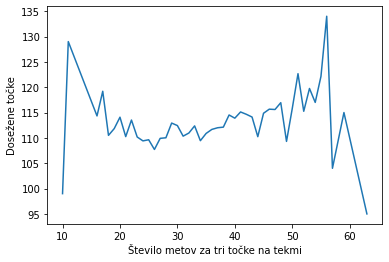

In [335]:
tekme_redne.groupby("3PA")["PTS"].mean().plot(xlabel="Število metov za tri točke na tekmi", ylabel="Dosežene točke")

<AxesSubplot:xlabel='Število metov za tri točke na tekmi', ylabel='Nasprotnikove točke'>

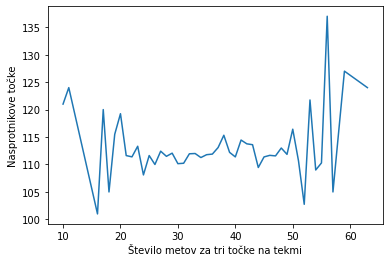

In [336]:
tekme_redne.groupby("3PA")["PTSA"].mean().plot(xlabel="Število metov za tri točke na tekmi", ylabel="Nasprotnikove točke")

<AxesSubplot:xlabel='Število metov za tri točke na tekmi', ylabel='Število skokov na tekmi'>

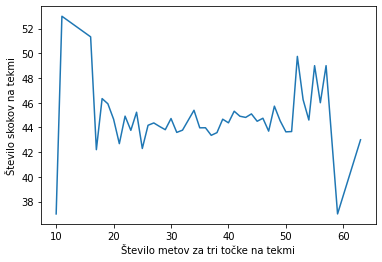

In [337]:
tekme_redne.groupby("3PA")["REB"].mean().plot(xlabel="Število metov za tri točke na tekmi", ylabel="Število skokov na tekmi")

<AxesSubplot:xlabel='Število metov za tri točke na tekmi', ylabel='Asistence'>

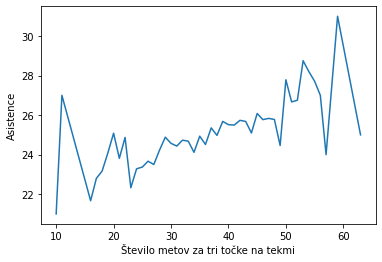

In [338]:
tekme_redne.groupby("3PA")["AST"].mean().plot(xlabel="Število metov za tri točke na tekmi", ylabel="Asistence")

<AxesSubplot:xlabel='Število metov za tri točke v sezoni', ylabel='Točke v sezoni'>

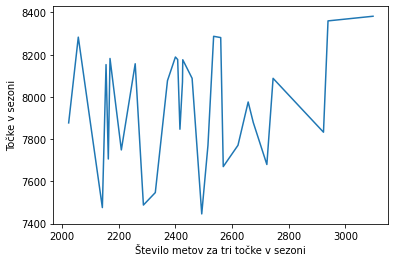

In [339]:
ekipe_redno.groupby("3PA")["PTS"].mean().plot(xlabel="Število metov za tri točke v sezoni", ylabel="Točke v sezoni")

<AxesSubplot:xlabel='Število metov za tri točke v sezoni', ylabel='Skupne točke nasprotnikov v sezoni'>

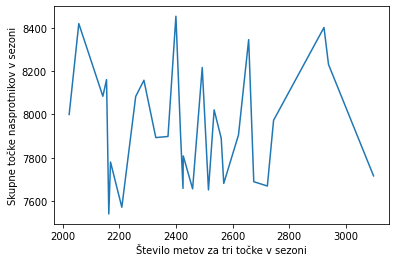

In [340]:
ekipe_redno.groupby("3PA")["PTSA"].mean().plot(xlabel="Število metov za tri točke v sezoni", ylabel="Skupne točke nasprotnikov v sezoni")

<AxesSubplot:xlabel='Število metov za tri točke v sezoni', ylabel='Skupno število skokov v sezoni'>

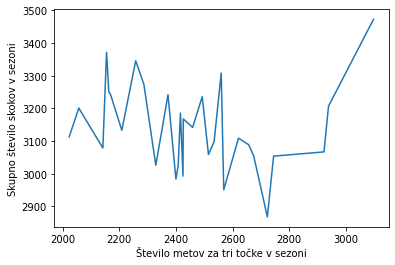

In [341]:
ekipe_redno.groupby("3PA")["REB"].mean().plot(xlabel="Število metov za tri točke v sezoni", ylabel="Skupno število skokov v sezoni")

<AxesSubplot:xlabel='Število metov za tri točke v sezoni', ylabel='Skupno število skokov v sezoni'>

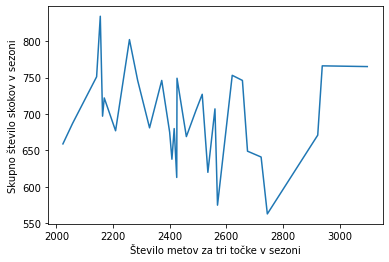

In [342]:
ekipe_redno.groupby("3PA")["OREB"].mean().plot(xlabel="Število metov za tri točke v sezoni", ylabel="Skupno število skokov v sezoni")

<AxesSubplot:xlabel='Število metov za tri točke v sezoni', ylabel='Skupno število asistenc v sezoni'>

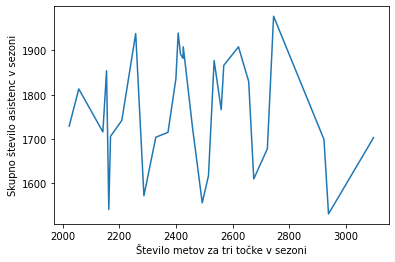

In [343]:
ekipe_redno.groupby("3PA")["AST"].mean().plot(xlabel="Število metov za tri točke v sezoni", ylabel="Skupno število asistenc v sezoni")

<AxesSubplot:xlabel='Usepšnost meta za tri točke na tekmi', ylabel='Dosežene točke'>

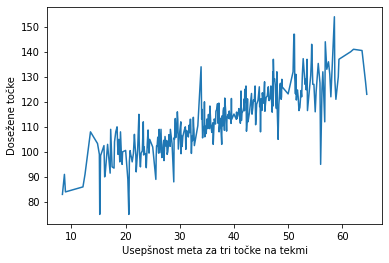

In [344]:
tekme_redne.groupby("3P%")["PTS"].mean().plot(xlabel="Usepšnost meta za tri točke na tekmi", ylabel="Dosežene točke")

<AxesSubplot:xlabel='Uspešnost meta za tri točke na tekmi', ylabel='Dosežene točke'>

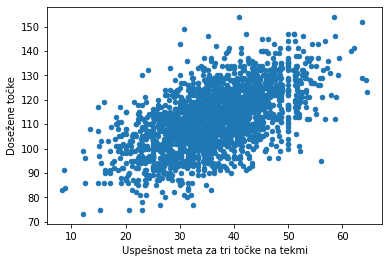

In [345]:
tekme_redne.plot.scatter("3P%","PTS",xlabel="Uspešnost meta za tri točke na tekmi", ylabel="Dosežene točke")

<AxesSubplot:xlabel='Uspešnost meta za tri točke na tekmi', ylabel='Nasprotnikove točke'>

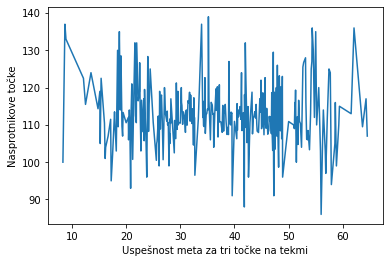

In [346]:
tekme_redne.groupby("3P%")["PTSA"].mean().plot(xlabel="Uspešnost meta za tri točke na tekmi", ylabel="Nasprotnikove točke")

<AxesSubplot:xlabel='Uspešnost meta za tri točke na tekmi', ylabel='Število skokov na tekmi'>

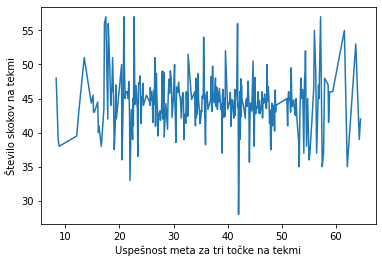

In [347]:
tekme_redne.groupby("3P%")["REB"].mean().plot(xlabel="Uspešnost meta za tri točke na tekmi", ylabel="Število skokov na tekmi")

<AxesSubplot:xlabel='Uspešnost meta za tri točke na tekmi', ylabel='Asistence'>

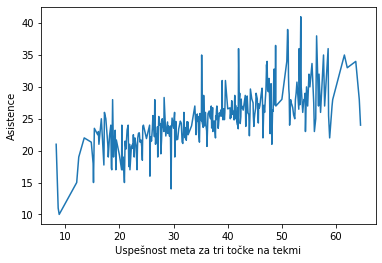

In [348]:
tekme_redne.groupby("3P%")["AST"].mean().plot(xlabel="Uspešnost meta za tri točke na tekmi", ylabel="Asistence")

<AxesSubplot:xlabel='Uspešnost meta za tri točke na tekmi', ylabel='Asistence'>

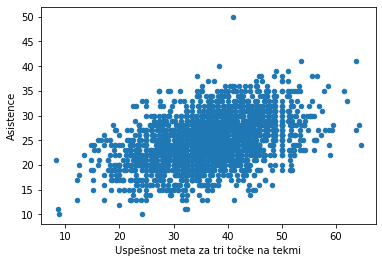

In [349]:
tekme_redne.plot.scatter("3P%","AST",xlabel="Uspešnost meta za tri točke na tekmi", ylabel="Asistence")

<AxesSubplot:xlabel='Uspešnost meta za tri točke v sezoni', ylabel='Točke v sezoni'>

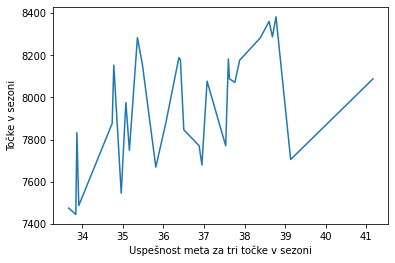

In [350]:
ekipe_redno.groupby("3P%")["PTS"].mean().plot(xlabel="Uspešnost meta za tri točke v sezoni", ylabel="Točke v sezoni")

<AxesSubplot:xlabel='Uspešnost meta za tri točke v sezoni', ylabel='Skupne točke nasprotnikov v sezoni'>

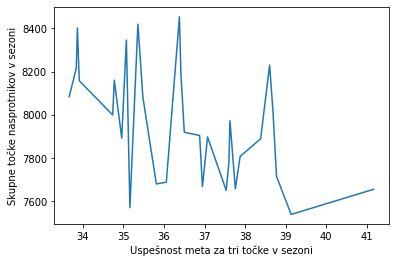

In [351]:
ekipe_redno.groupby("3P%")["PTSA"].mean().plot(xlabel="Uspešnost meta za tri točke v sezoni", ylabel="Skupne točke nasprotnikov v sezoni")

<AxesSubplot:xlabel='Uspešnost meta za tri točke v sezoni', ylabel='Skupno število skokov v sezoni'>

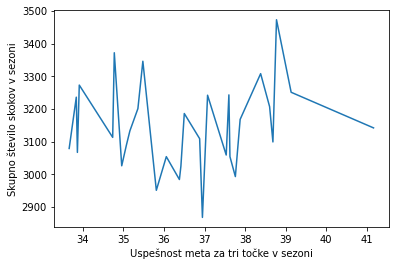

In [352]:
ekipe_redno.groupby("3P%")["REB"].mean().plot(xlabel="Uspešnost meta za tri točke v sezoni", ylabel="Skupno število skokov v sezoni")

<AxesSubplot:xlabel='Uspešnost meta za tri točke v sezoni', ylabel='Skupno število skokov v sezoni'>

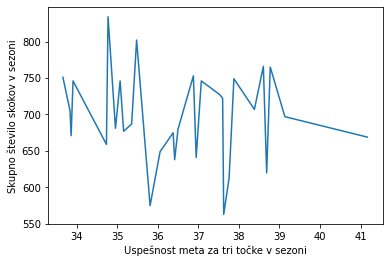

In [353]:
ekipe_redno.groupby("3P%")["OREB"].mean().plot(xlabel="Uspešnost meta za tri točke v sezoni", ylabel="Skupno število skokov v sezoni")

<AxesSubplot:xlabel='Uspešnost meta za tri točke v sezoni', ylabel='Skupno število asistenc v sezoni'>

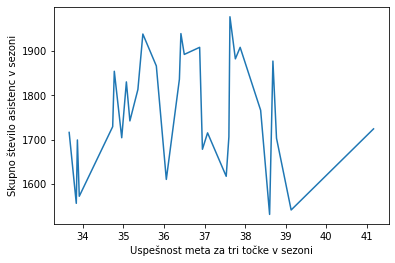

In [354]:
ekipe_redno.groupby("3P%")["AST"].mean().plot(xlabel="Uspešnost meta za tri točke v sezoni", ylabel="Skupno število asistenc v sezoni")

# Napol Nostradamus

Napisal bom program, ki sprejme podatek o tem, kako uspešno sta dve ekipi metali za tri in kolikokrat sta metali za tri, in na podlagi tega poskusi uganiti končni rezultat tekme.

In [355]:
def zaokrozi_na_desetice(x):
    return x - (x % 10)

zdruzena_statistika = [[], [], [], [], []]

for i in range(tekme_redne["PTS"].size//2):
    zdruzena_statistika[0].append(tekme_redne["3P%"].iloc[2 * i])
    zdruzena_statistika[1].append(tekme_redne["3P%"].iloc[2 * i + 1])
    zdruzena_statistika[2].append(tekme_redne["3PA"].iloc[2 * i])
    zdruzena_statistika[3].append(tekme_redne["3PA"].iloc[2 * i + 1])
    zdruzena_statistika[4].append((zaokrozi_na_desetice(tekme_redne["PTS"].iloc[2 * i]), zaokrozi_na_desetice(tekme_redne["PTS"].iloc[2 * i + 1])))

data = {"3P% HOME" : zdruzena_statistika[0], "3P% AWAY" : zdruzena_statistika[1], "3PA HOME" : zdruzena_statistika[2],
    "3PA AWAY" : zdruzena_statistika[3], "Class" : zdruzena_statistika[4]}

zdruzene_tekme = pd.DataFrame(data)

In [356]:
verjetnosti_kategorij = zdruzene_tekme.groupby("Class").size()/len(zdruzene_tekme)
verjetnosti_kategorij = verjetnosti_kategorij.to_dict()

In [357]:
import random

def napovej(procenti1, meti1, procenti2, meti2):
    ustrezni = zdruzene_tekme[((abs(zdruzene_tekme["3P% HOME"] - procenti1) < 2) & (abs(zdruzene_tekme["3P% AWAY"] - procenti2) < 2)
                                & (abs(zdruzene_tekme["3PA HOME"] - meti1) < 10) & (abs(zdruzene_tekme["3PA AWAY"] - meti2) < 10)) |
                                ((abs(zdruzene_tekme["3P% HOME"] - procenti2) < 2) & (abs(zdruzene_tekme["3P% AWAY"] - procenti1) < 2)
                                & (abs(zdruzene_tekme["3PA HOME"] - meti2) < 10) & (abs(zdruzene_tekme["3PA AWAY"] - meti1) < 10))]
    
    pojavitve_po_kategorijah = ustrezni.groupby("Class").size().to_dict()

    max_kategorija = (0,0)
    mx = 0
    
    for kategorija in pojavitve_po_kategorijah.keys():
        if (pojavitve_po_kategorijah[kategorija]/zdruzene_tekme.groupby("Class").size()[kategorija]) * verjetnosti_kategorij[kategorija] > mx:
            max_kategorija = kategorija
            mx = (pojavitve_po_kategorijah[kategorija]/zdruzene_tekme.groupby("Class").size()[kategorija]) * verjetnosti_kategorij[kategorija]

    answer = (max_kategorija[0] + random.randrange(10), max_kategorija[1] + random.randrange(10))

    if answer[0] == answer[1]:
        if answer[0] == 0:
            answer[0] = answer[0] + 1
        else:
            answer[0] = answer[0] - 1
    
    return (max_kategorija[0] + random.randrange(10), max_kategorija[1] + random.randrange(10))


napovej(51.3, 39, 35.9, 39)

(103.0, 128.0)